In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

from keras.layers import Dense, Input
from keras.models import Sequential, Model  # functional API
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam

from keras.datasets import mnist


In [2]:
(X_train,_),(_,_) = mnist.load_data()  # we need only X_train since GAN is unsupervised 

In [3]:
X_train.shape

(60000, 28, 28)

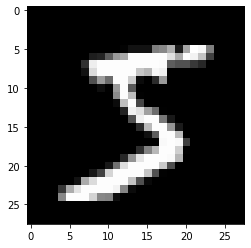

In [4]:
plt.imshow(X_train[0], cmap='gray')
plt.show()

In [5]:
X_train = X_train.reshape(len(X_train), -1)

In [6]:
X_train.shape

(60000, 784)

In [7]:
# sigma = X_train.std(axis=0)
# sigma = [s if s != 0 else 1 for s in sigma]

In [8]:
# X_train = (X_train.astype('float32') - X_train.mean(axis=0))/sigma

In [9]:
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [10]:
X_train = (X_train.reshape(len(X_train), -1).astype('float32') - 127.5)/127.5  # bring every pixel value in the range [-1, 1]

In [11]:
X_train.shape

(60000, 784)

In [12]:
noise_dim = 100  # will be upscaled to 28x28=784 dim vector
pic_dim = X_train.shape[1]

In [13]:
# Generator
# inputs noise, and outputs a 784 dim vector

generator = Sequential()
generator.add(Dense(256, input_shape=(noise_dim,), activation=LeakyReLU(0.2)))
generator.add(Dense(512, activation=LeakyReLU(0.2)))
generator.add(Dense(1024, activation=LeakyReLU(0.2)))
generator.add(Dense(pic_dim, activation='tanh'))

generator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=2e-4, beta_1=0.5) )  # loss works best for GAN
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 dense_3 (Dense)             (None, 784)               803600    
                                                                 
Total params: 1,486,352
Trainable params: 1,486,352
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Discriminator
# downsamples image from 784 dim to 1

discriminator = Sequential()
discriminator.add(Dense(512, input_shape=(pic_dim,), activation=LeakyReLU(0.2)))
discriminator.add(Dense(256, activation=LeakyReLU(0.2)))
discriminator.add(Dense(1, activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=2e-4, beta_1=0.5))  # note that when we call this compile function, the discriminator is not frozen
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512)               401920    
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dense_6 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


In [15]:
# create the model by connecting generator and discriminator
discriminator.trainable = False  # this won't have any effect on discriminator until we compile the discriminator again
input = Input(shape=(noise_dim,))
generator_output = generator(input)
discriminator_output = discriminator(generator_output)

model = Model(input, discriminator_output)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=2e-4, beta_1=0.5))  
model.summary()
# when we call this compile function, the discriminator was frozen when called inside the model, but the 'discriminator' object that we made hasn't been compiled again. So, it is still unfrozen if we call it explicitly.
# So, to summarize, whenever we will train the object 'model', discriminator will be frozen, however when we just train the object 'discriminator', it will be unfrozen, even though 'model' internally contains a pointer to 'discriminator' object only

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 784)               1486352   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 533505    
                                                                 
Total params: 2,019,857
Trainable params: 1,486,352
Non-trainable params: 533,505
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [16]:
def draw_images(epoch_no, num_samples=5):
    plt.figure(figsize=(10, 20))
    num_samples = 5
    noise_matrix = np.random.normal(0, 1, size=(num_samples, noise_dim))  # random noise vectors for every image sampled from a gaussian distribution
    generated_images = generator.predict(noise_matrix).reshape(num_samples, int(np.sqrt(X_train.shape[1])), int(np.sqrt(X_train.shape[1])))
    index = epoch_no
    for i in range(num_samples):
        plt.subplot(epochs/5, 5, index+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
        index += 1
    plt.show()

epoch: 0, epoch dis loss: 157.0, epoch gen loss: 391.7


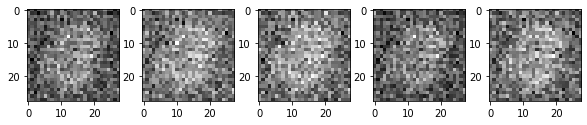

epoch: 1, epoch dis loss: 109.9, epoch gen loss: 681.3
epoch: 2, epoch dis loss: 96.29, epoch gen loss: 828.5
epoch: 3, epoch dis loss: 90.99, epoch gen loss: 885.1
epoch: 4, epoch dis loss: 87.79, epoch gen loss: 926.3
epoch: 5, epoch dis loss: 85.1, epoch gen loss: 951.6


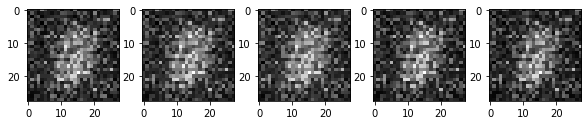

epoch: 6, epoch dis loss: 83.36, epoch gen loss: 969.1
epoch: 7, epoch dis loss: 83.14, epoch gen loss: 974.4
epoch: 8, epoch dis loss: 82.26, epoch gen loss: 988.8
epoch: 9, epoch dis loss: 81.43, epoch gen loss: 991.4
epoch: 10, epoch dis loss: 82.74, epoch gen loss: 951.1


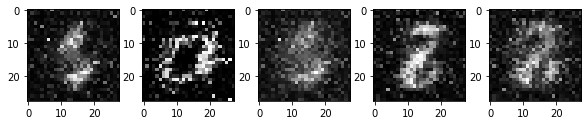

epoch: 11, epoch dis loss: 81.87, epoch gen loss: 970.0
epoch: 12, epoch dis loss: 82.08, epoch gen loss: 954.9
epoch: 13, epoch dis loss: 81.94, epoch gen loss: 958.1
epoch: 14, epoch dis loss: 81.05, epoch gen loss: 970.0
epoch: 15, epoch dis loss: 81.07, epoch gen loss: 967.5


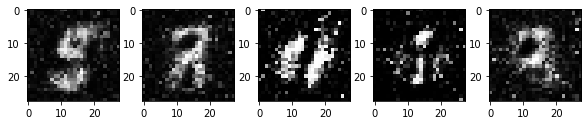

epoch: 16, epoch dis loss: 81.08, epoch gen loss: 956.2
epoch: 17, epoch dis loss: 81.61, epoch gen loss: 950.1
epoch: 18, epoch dis loss: 81.76, epoch gen loss: 928.6
epoch: 19, epoch dis loss: 82.17, epoch gen loss: 915.8
epoch: 20, epoch dis loss: 82.27, epoch gen loss: 906.9


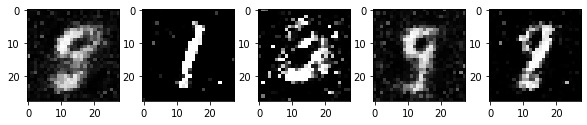

epoch: 21, epoch dis loss: 82.88, epoch gen loss: 880.2
epoch: 22, epoch dis loss: 83.08, epoch gen loss: 872.2
epoch: 23, epoch dis loss: 83.14, epoch gen loss: 874.4
epoch: 24, epoch dis loss: 83.08, epoch gen loss: 870.8
epoch: 25, epoch dis loss: 83.39, epoch gen loss: 859.2


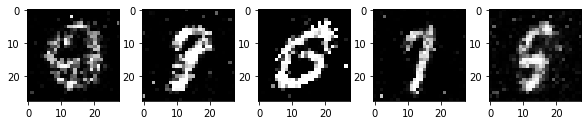

epoch: 26, epoch dis loss: 83.34, epoch gen loss: 860.3
epoch: 27, epoch dis loss: 83.36, epoch gen loss: 861.9
epoch: 28, epoch dis loss: 83.43, epoch gen loss: 858.3
epoch: 29, epoch dis loss: 83.71, epoch gen loss: 850.8
epoch: 30, epoch dis loss: 83.62, epoch gen loss: 850.3


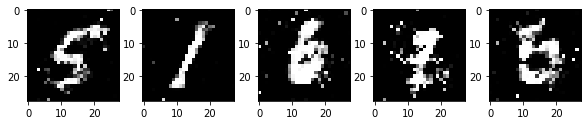

epoch: 31, epoch dis loss: 83.54, epoch gen loss: 851.2
epoch: 32, epoch dis loss: 83.72, epoch gen loss: 847.8
epoch: 33, epoch dis loss: 83.88, epoch gen loss: 844.9
epoch: 34, epoch dis loss: 83.72, epoch gen loss: 846.6
epoch: 35, epoch dis loss: 83.76, epoch gen loss: 846.7


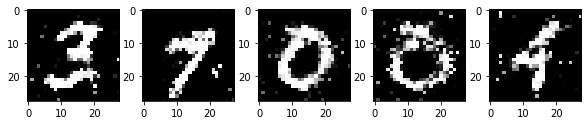

epoch: 36, epoch dis loss: 83.88, epoch gen loss: 844.5
epoch: 37, epoch dis loss: 84.03, epoch gen loss: 840.2
epoch: 38, epoch dis loss: 83.99, epoch gen loss: 839.9
epoch: 39, epoch dis loss: 83.95, epoch gen loss: 839.9
epoch: 40, epoch dis loss: 84.0, epoch gen loss: 838.8


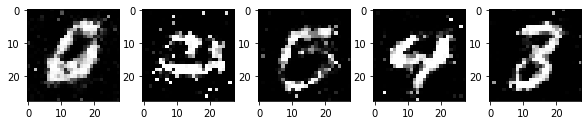

epoch: 41, epoch dis loss: 84.11, epoch gen loss: 838.1
epoch: 42, epoch dis loss: 84.07, epoch gen loss: 835.5
epoch: 43, epoch dis loss: 84.13, epoch gen loss: 837.2
epoch: 44, epoch dis loss: 84.2, epoch gen loss: 834.2
epoch: 45, epoch dis loss: 84.19, epoch gen loss: 834.4


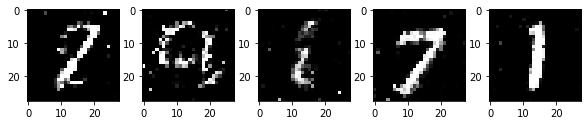

epoch: 46, epoch dis loss: 84.2, epoch gen loss: 835.1
epoch: 47, epoch dis loss: 84.09, epoch gen loss: 834.5
epoch: 48, epoch dis loss: 84.13, epoch gen loss: 835.9
epoch: 49, epoch dis loss: 84.27, epoch gen loss: 833.3


In [17]:
# training
epochs = 50
batch_size = 256
no_of_batches = int(len(X_train)/batch_size)

for epoch in range(epochs):
    generator_tot_epoch_loss = 0
    discriminator_tot_epoch_loss = 0

    # mini-batch SGD
    for step in range(no_of_batches):

        # first, train the discriminator using 50% real data and 50% generated data
        real_batch_size = batch_size//2
        fake_batch_size = batch_size - real_batch_size

        real_batch = X_train[step*batch_size:(step+1)*batch_size]
        real_half_indices = np.random.randint(0, batch_size, size=real_batch_size)
        real_half_batch = real_batch[real_half_indices]

        noise_matrix = np.random.normal(0, 1, size=(fake_batch_size, noise_dim))  # random noise vectors for every image sampled from a gaussian distribution
        fake_half_batch = generator.predict(noise_matrix)

        y_real = np.ones((real_batch_size, 1))*0.09  # one side label smoothing for discriminator
        y_fake = np.zeros((fake_batch_size, 1))

        discriminator_real_loss = discriminator.train_on_batch(real_half_batch, y_real)  # training only the discriminator
        discriminator_fake_loss = discriminator.train_on_batch(fake_half_batch, y_fake)
        discriminator_tot_batch_loss = discriminator_real_loss + discriminator_fake_loss
        discriminator_tot_epoch_loss += discriminator_tot_batch_loss

        # next, train the generator by after freezing the discriminator
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
        y_ground_truth = np.ones((batch_size, 1))
        generator_tot_batch_loss = model.train_on_batch(noise, y_ground_truth)  # trains only the generator since discriminator is frozen
        generator_tot_epoch_loss += generator_tot_batch_loss

    print(f"epoch: {epoch}, epoch dis loss: {discriminator_tot_epoch_loss:.4}, epoch gen loss: {generator_tot_epoch_loss:.4}")
    
    if epoch%5==0:
        draw_images(epoch)